In [23]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from glob import glob
from PIL import Image
import seaborn as sns
import math
import random
import xarray as xr
from torch.masked import masked_tensor, as_masked_tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

In [8]:
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [9]:
#train_path_list

In [10]:
train_path_list[0]

'/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train/ASO_50M_SD_RoaringFork_20230528_clean_tile80_s15.nc'

In [11]:
ds = xr.open_dataset(train_path_list[0])
ds

<xarray.Dataset>
Dimensions:           (y: 128, x: 128)
Coordinates:
    band              int64 ...
  * x                 (x) float64 3.447e+05 3.447e+05 ... 3.51e+05 3.51e+05
  * y                 (y) float64 4.333e+06 4.333e+06 ... 4.327e+06 4.326e+06
    time              datetime64[ns] ...
    spatial_ref       int64 ...
Data variables: (12/30)
    aso_sd            (y, x) float32 ...
    snowon_vh         (y, x) float32 ...
    snowon_vv         (y, x) float32 ...
    snowoff_vh        (y, x) float32 ...
    snowoff_vv        (y, x) float32 ...
    snowon_vh_mean    (y, x) float32 ...
    ...                ...
    visual            (y, x) float32 ...
    fcf               (y, x) float64 ...
    elevation         (y, x) float32 ...
    aso_gap_map       (y, x) int64 ...
    rtc_gap_map       (y, x) int64 ...
    rtc_mean_gap_map  (y, x) int64 ...

In [233]:
ds.time

<xarray.DataArray 'time' ()>
array('2017-07-31T13:59:37.445152000', dtype='datetime64[ns]')
Coordinates:
    band         int64 1
    time         datetime64[ns] 2017-07-31T13:59:37.445152
    spatial_ref  int64 0

In [234]:
ds.time.values

numpy.datetime64('2017-07-31T13:59:37.445152000')

(array([1.5686e+04, 4.9100e+02, 1.1400e+02, 5.2000e+01, 1.7000e+01,
        1.4000e+01, 6.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 0.        ,  1.00942957,  2.01885915,  3.0282886 ,  4.0377183 ,
         5.04714775,  6.05657721,  7.06600666,  8.07543659,  9.08486557,
        10.0942955 ]),
 <BarContainer object of 10 artists>)

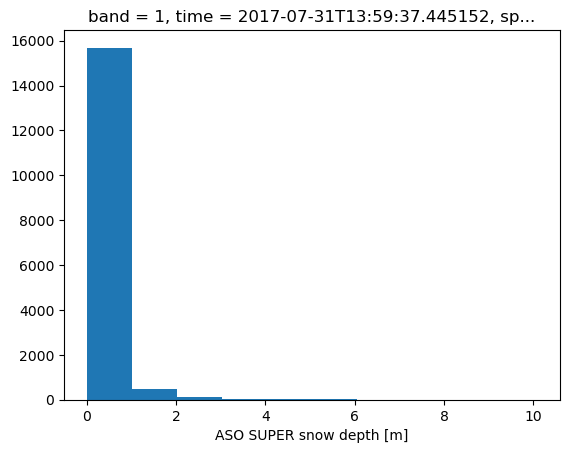

In [232]:
ds.aso_sd.plot.hist()

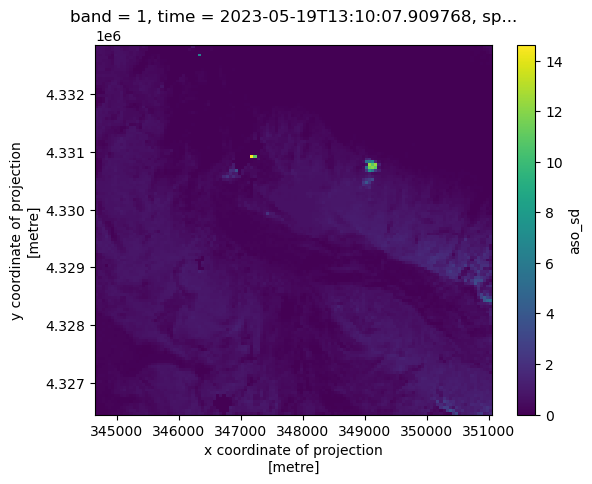

In [51]:
ds.aso_sd.plot()

In [34]:
def calc_norm(tensor, minmax_list):
    '''
    normalize a tensor between 0 and 1 using a min and max value stored in a list
    '''
    normalized = (tensor-minmax_list[0])/(minmax_list[1]-minmax_list[0])
    return normalized

In [47]:
len(train_path_list)

25051

In [56]:
# (Re-)Create norm_dict from training dataset
# aka, an exercise to get acquainted with xarray!
start_time = time.perf_counter()
for i, d in enumerate(train_path_list):
    ds = xr.open_dataset(d)
    if i == 0:
        var_list = list(ds.data_vars)
        range_dict = dict({k: [np.inf, -np.inf] for k in var_list})
    for var in var_list:
        cur_max = ds[var].values.max()
        cur_min = ds[var].values.min()
        if cur_max>range_dict[var][1]: range_dict[var][1] = cur_max
        if cur_min<range_dict[var][0]: range_dict[var][0] = cur_min
runtime = time.perf_counter()-start_time
print('run time = {:.4f} minutes'.format(runtime/60))
range_dict

run time = 59.0072 minutes


{'aso_sd': [0.0, 24.83628],
 'snowon_vh': [0.0, 35.78091],
 'snowon_vv': [0.0, 8774.097],
 'snowoff_vh': [0.0, 36.05591],
 'snowoff_vv': [0.0, 13523.74],
 'snowon_vh_mean': [0.0, 43.186153],
 'snowon_vv_mean': [0.0, 4794.3115],
 'snowoff_vh_mean': [0.0, 30.40638],
 'snowoff_vv_mean': [0.0, 10761.114],
 'AOT': [0.0, 572.0],
 'B01': [0.0, 23459.0],
 'B02': [0.0, 23004.0],
 'B03': [0.0, 26440.0],
 'B04': [0.0, 21576.0],
 'B05': [0.0, 20796.0],
 'B06': [0.0, 20432.0],
 'B07': [0.0, 20149.0],
 'B08': [0.0, 21217.0],
 'B09': [0.0, 18199.0],
 'B11': [0.0, 17549.0],
 'B12': [0.0, 17314.0],
 'B8A': [0.0, 20981.0],
 'SCL': [0.0, 15.0],
 'WVP': [0.0, 6517.438],
 'visual': [0.0, 255.0],
 'fcf': [0.0, 1.0],
 'elevation': [0.0, 4408.2915],
 'aso_gap_map': [0, 1],
 'rtc_gap_map': [0, 1],
 'rtc_mean_gap_map': [0, 1]}

In [4]:
# these are set by finding the min and max across the entire dataset
norm_dict = {'aso_sd':[0, 24.9],
             'vv':[0, 13523.8],
             'vh':[0, 43.2],
             'AOT':[0, 572.1],
             'coastal':[0, 23459.1],
             'blue':[0, 23004.1],
             'green':[0, 26440.1],
             'red':[0, 21576.1],
             'red_edge1':[0, 20796.1],
             'red_edge2':[0, 20432.1],
             'red_edge3':[0, 20149.1],
             'nir':[0, 21217.1],
             'water_vapor':[0, 18199.1],
             'swir1':[0, 17549.1],
             'swir2':[0, 17314.1],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6517.5],
             'elevation':[-100, 9000]}